# Base models

Testing different base models

- Decision Tree
- Logistic Regression
- Random Forest
- Support Vector Machines

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import lightgbm as ltb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, evaluator, Model
from utils import plot_results

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [2]:
CLASS_COL = 'class'

OFFLINE_PHASE_SIZE = 10000
LEARNING_WINDOW_SIZE = 5000
BASE_TRAIN_SIZE = 7000
META_TRAIN_SIZE = 0.5
R_STATE = 123

ETA = 100  # Window size used to extract meta features
STEP = 30  # Step for next meta learning iteration
KNOWN_TARGET_WINDOW_SIZE = 0  # Target is unknown

MODEL_LIST = [
    {'name': 'logistic_regression', 'type': LogisticRegression, 'hyperparameters': {'random_state': R_STATE}},
    {'name': 'random_forest', 'type': RandomForestClassifier, 'hyperparameters': {'random_state': R_STATE, 'max_depth': 6}},
    {'name': 'svm', 'type': SVC, 'hyperparameters': {'random_state': R_STATE, 'probability': True}},
    {'name': 'decision_tree', 'type': DecisionTreeClassifier, 'hyperparameters': {'random_state': R_STATE, 'max_depth': 6}},
]

## Read data

In [3]:
f = open("../datasets/real/elec.arff", "r")
data, meta = arff.loadarff(f)

df = pd.DataFrame(data)
df['weekday'] = pd.to_numeric(df['day'])
df['class'] = df['class'].str.decode("utf-8")
df = df.drop(['date', 'period', 'day'], axis=1)

print(df.shape)
df.head()

(45312, 7)


,nswprice,nswdemand,vicprice,vicdemand,transfer,class,weekday
0,0.056443,0.439155,0.003467,0.422915,0.414912,UP,2
1,0.051699,0.415055,0.003467,0.422915,0.414912,UP,2
2,0.051489,0.385004,0.003467,0.422915,0.414912,UP,2
3,0.045485,0.314639,0.003467,0.422915,0.414912,UP,2
4,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,2


In [4]:
n = df.shape[0]
class_weight = df['class'].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5754546257062146, 'UP': 0.4245453742937853}

In [5]:
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
validation_df = online_df.iloc[:int(OFFLINE_PHASE_SIZE*META_TRAIN_SIZE)]

## Fase offline para diferentes modelos

In [6]:
learners = {}

for model in MODEL_LIST:
    base_model = Model(basis_model=model['type'], hyperparameters=model['hyperparameters'])
    meta_model = Model(basis_model=ltb.LGBMRegressor, hyperparameters={'num_leaves': 21, 'max_depth': 5})

    learner = MetaLearner(
        base_model=base_model,
        meta_model=meta_model,
        base_model_class_column=CLASS_COL,
        meta_label_metric='precision',
        eta=ETA,
        step=STEP,
        known_target_window_size=KNOWN_TARGET_WINDOW_SIZE,
        learning_window_size=LEARNING_WINDOW_SIZE,
        )

    learner.fit(offline_df)
    learners[model['name']] = learner

In [7]:
# BASELINE
results = []

for model_name, learner in learners.items():
    metric = learner.meta_label_metric
    y_true = learner.meta_base[metric]
    y_pred = [np.mean(y_true)] * len(y_true)
    r2 = evaluator.evaluate(y_true, y_pred, 'r2')
    mse = evaluator.evaluate(y_true, y_pred, 'mse')
    std = evaluator.evaluate(y_true, y_pred, 'std')
    results.append({'r2': r2, 'mse': mse, 'std': std, 'model': model_name, 'type': 'baseline'})

pd.DataFrame(results)

,r2,mse,std,model,type
0,0.0,0.023230,0.152413,logistic_regression,baseline
1,0.0,0.022559,0.150195,random_forest,baseline
2,0.0,0.016754,0.129439,svm,baseline
3,0.0,0.030648,0.175064,decision_tree,baseline


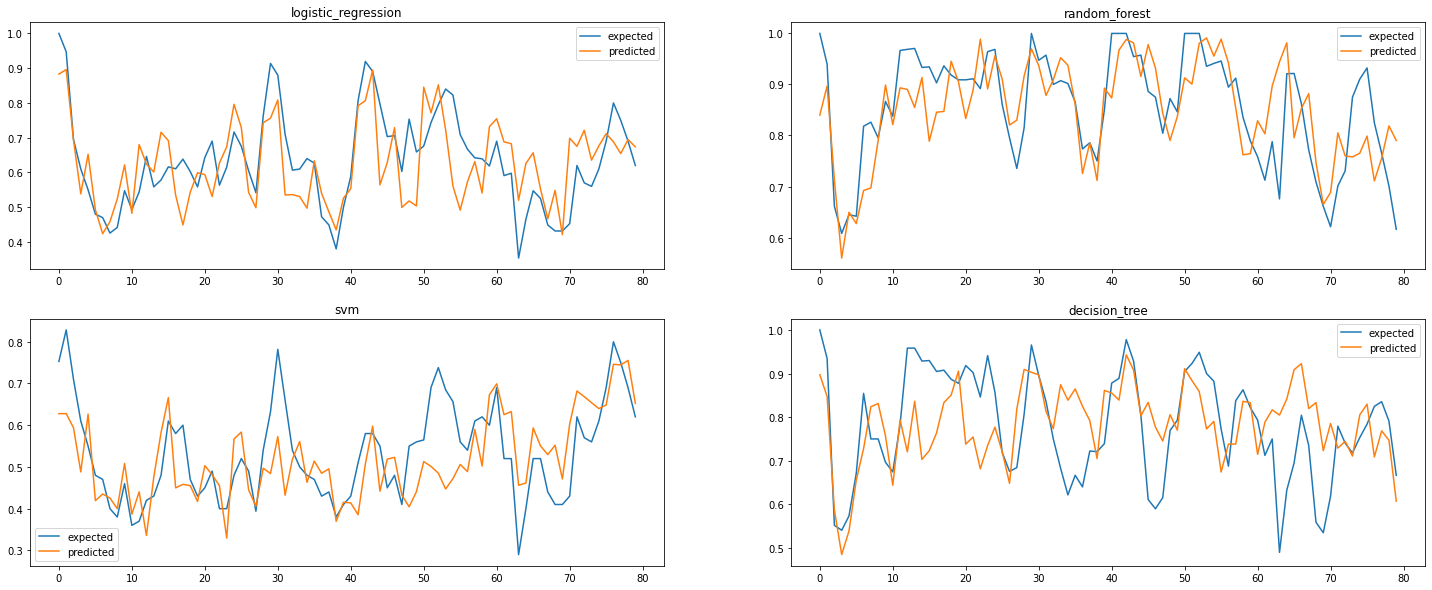

In [8]:
fig = plt.figure(figsize=(25, 10))
model_dict = {}
idx = 0

for model_name, learner in learners.items():
    metric = learner.meta_label_metric
    val_base = learner._get_offline_metabase(validation_df)
    model = learner.meta_model

    X, y_true = val_base.drop(learner.performance_metrics, axis=1), val_base[metric]
    y_pred = model.predict(X)

    result = plot_results(y_true, y_pred, title=model_name, idx=idx, subplot_index=(2, 2))
    model_dict[model_name] = learner.meta_model.model
    idx += 1

    result = {**result, **{'model': model_name, 'type': 'meta learning'}}
    results.append(result)

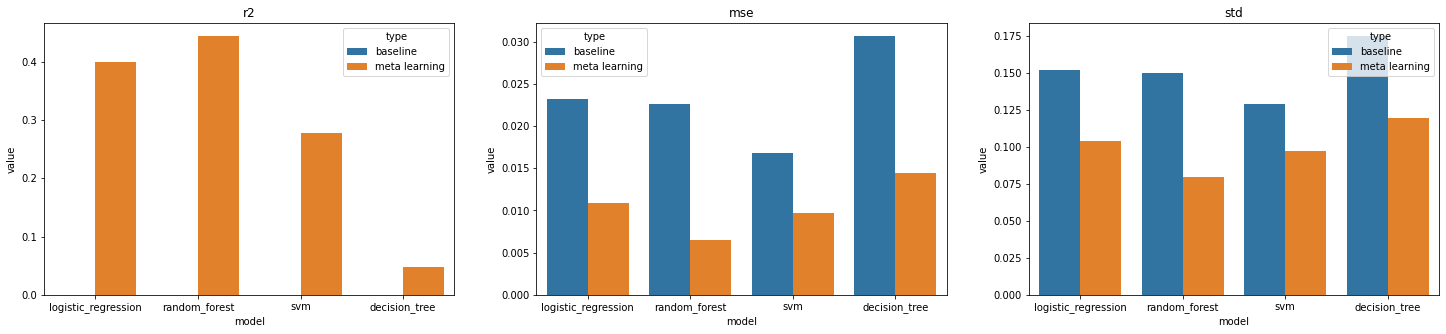

In [9]:
results_models = pd.DataFrame(results)
fig = plt.figure(figsize=(25, 5))

df_plot = pd.melt(results_models, id_vars=['model', 'type'], value_vars=evaluator.reg_metrics)

for idx, metric in enumerate(evaluator.reg_metrics):
    plt.subplot(1, 3, idx + 1)
    this_metric = df_plot[df_plot['variable'] == metric]
    sns.barplot(x="model", y='value', hue='type', data=this_metric)
    plt.title(metric)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

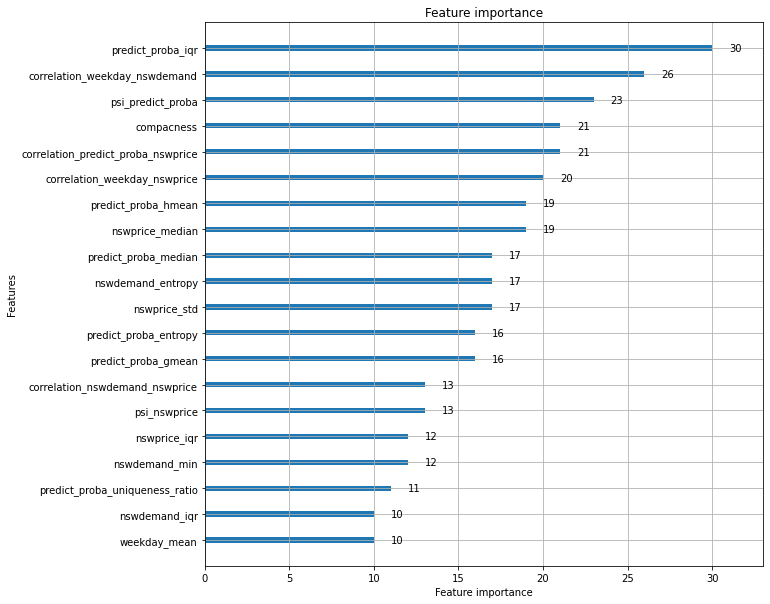

In [10]:
model_name = 'random_forest'
ltb.plot_importance(model_dict[model_name], figsize=(10, 10), max_num_features=20)